## __Import__

In [1]:
import pandas as pd
import numpy as np
import math
from statsbombpy import sb
from ast import literal_eval
from dataloader import load_data
from mplsoccer import Pitch, VerticalPitch, Standardizer


def load_event_data(match=False):
    if match:
        COMPETITION_ID = 9
        SEASON_ID = 27
        MATCH_ID = 3890561 
        df = sb.events(match_id=MATCH_ID)
        return df
    else:
        df = load_data(frac=(1))
        return df

MATCH=False
df = load_event_data(match=MATCH)

[2025-03-05 13:10:34] File exists
[2025-03-05 13:10:34] Loading data form local file system


c:\Users\Alexander Lorenz\Documents\GitHub\ai-fc\src\dataloader.py:76: DtypeWarning: Columns (2,10,12,16,18,39,40,42,65,71,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path).sample(frac=frac, random_state=42)


[2025-03-05 13:10:45] File loaded with shape: (1069866, 115)


In [2]:
columns = ["player","location","type","under_pressure" ,"goalkeeper_position", "goalkeeper_technique","goalkeeper_body_part","goalkeeper_type","goalkeeper_outcome"]
df = df.loc[(df["type"]=="Goal Keeper"),columns]
df 

,player,location,type,under_pressure,goalkeeper_position,goalkeeper_technique,goalkeeper_body_part,goalkeeper_type,goalkeeper_outcome
411161,Christian Mathenia,"[7.7, 47.2]",Goal Keeper,NaN,NaN,NaN,NaN,Keeper Sweeper,Claim
494861,Roman Bürki,"[4.2, 40.5]",Goal Keeper,NaN,Set,NaN,NaN,Shot Faced,NaN
741502,Rune Almenning Jarstein,"[3.3, 34.2]",Goal Keeper,NaN,NaN,NaN,NaN,Punch,Punched out
942205,Roman Bürki,"[1.2, 38.7]",Goal Keeper,NaN,Set,NaN,NaN,Shot Faced,NaN
865408,Diego Orlando Benaglio,"[2.3, 39.7]",Goal Keeper,NaN,Set,Diving,NaN,Goal Conceded,No Touch
...,...,...,...,...,...,...,...,...,...
269544,Christian Mathenia,"[1.9, 39.7]",Goal Keeper,NaN,Set,NaN,NaN,Shot Faced,NaN
983237,Timo Horn,"[1.9, 37.8]",Goal Keeper,NaN,Set,NaN,NaN,Shot Faced,NaN
837291,Loris Karius,"[5.6, 38.5]",Goal Keeper,NaN,Set,NaN,NaN,Shot Faced,NaN
269536,Christian Mathenia,"[0.7, 44.0]",Goal Keeper,NaN,Set,Standing,Both Hands,Shot Saved,Success


## __Setting types__

In [3]:
## __Setting types__
def convert_to_list(input_data):
    if(isinstance(input_data, str)):
        try:
            return literal_eval(input_data)
        except (ValueError, SyntaxError):
            print(f"Error: The string {input_data} could not be converted to a list.")
            return None
    
    return input_data
    
df["location"] = df["location"].apply(convert_to_list)
df[["x", "y"]] = df["location"].apply(pd.Series)
df["under_pressure"] = df["under_pressure"] == True
df

,player,location,type,under_pressure,goalkeeper_position,goalkeeper_technique,goalkeeper_body_part,goalkeeper_type,goalkeeper_outcome,x,y
411161,Christian Mathenia,"[7.7, 47.2]",Goal Keeper,False,NaN,NaN,NaN,Keeper Sweeper,Claim,7.7,47.2
494861,Roman Bürki,"[4.2, 40.5]",Goal Keeper,False,Set,NaN,NaN,Shot Faced,NaN,4.2,40.5
741502,Rune Almenning Jarstein,"[3.3, 34.2]",Goal Keeper,False,NaN,NaN,NaN,Punch,Punched out,3.3,34.2
942205,Roman Bürki,"[1.2, 38.7]",Goal Keeper,False,Set,NaN,NaN,Shot Faced,NaN,1.2,38.7
865408,Diego Orlando Benaglio,"[2.3, 39.7]",Goal Keeper,False,Set,Diving,NaN,Goal Conceded,No Touch,2.3,39.7
...,...,...,...,...,...,...,...,...,...,...,...
269544,Christian Mathenia,"[1.9, 39.7]",Goal Keeper,False,Set,NaN,NaN,Shot Faced,NaN,1.9,39.7
983237,Timo Horn,"[1.9, 37.8]",Goal Keeper,False,Set,NaN,NaN,Shot Faced,NaN,1.9,37.8
837291,Loris Karius,"[5.6, 38.5]",Goal Keeper,False,Set,NaN,NaN,Shot Faced,NaN,5.6,38.5
269536,Christian Mathenia,"[0.7, 44.0]",Goal Keeper,False,Set,Standing,Both Hands,Shot Saved,Success,0.7,44.0


## __Generate Features__

In [54]:
def is_ex_inside_defending_goal_area(row):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    x = row["x"]
    y = row["y"]

    x_axis = ((0 <= x) and (x <= 6))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_ex_inside_defending_penalty_area(row):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120
    x = row["x"]
    y = row["y"]

    if is_ex_inside_defending_goal_area(row):
        return False
    else:
        x_axis = ((0 <= x) and (x <= 18)) 
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_inside_defending_third(row):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120
    x = row["x"]
    #y = row["y"]

    if is_ex_inside_defending_goal_area(row) or is_ex_inside_defending_penalty_area(row):
        return False
    else:
        return (x <= 40) 


def analyze_defending(df):
    """
    This function Pre-compute all conditions for Vectorize operations.
    Returns results grouped by player and under_pressure  
    """
    # Pre-compute all conditions
    df_with_flags = df.copy()

    # Action flags
    df_with_flags["is_shot_on_target"] = (df["goalkeeper_type"] =="Goal Conceded") | (df["goalkeeper_type"] =="Shot Saved") # nan for "Shot Saved Off T", "Shot Saved To Post"
    df_with_flags["goal_conceded"] = df["goalkeeper_type"] =="Goal Conceded"
    df_with_flags["is_dive"] = df["goalkeeper_technique"] =="Diving"
    df_with_flags["is_shot_saved"] = df["goalkeeper_type"] =="Shot Saved"
    df_with_flags["is_sweeper"] = df["goalkeeper_type"] =="Keeper Sweeper"
    df_with_flags["is_standing"] = df["goalkeeper_technique"] =="Standing"
    df_with_flags["is_penalty"] = (df["goalkeeper_type"] =="Penalty Conceded") | (df["goalkeeper_type"] =="Penalty Saved") | (df["goalkeeper_type"] =="Penalty Saved To Post")
    

    df_with_flags["is_penalty_saved"] = (df["goalkeeper_type"] =="Penalty Saved") | (df["goalkeeper_type"] =="Penalty Saved To Post")
    df_with_flags["is_punch"] = df["goalkeeper_type"] =="Punch"
    df_with_flags["is_shot_faced"] = df["goalkeeper_type"] =="Shot Faced"
    df_with_flags["is_ball_collecting"] = df["goalkeeper_type"] =="Collected"
    df_with_flags["is_smother"] = df["goalkeeper_type"] =="Smother"

    # location flags
    df_with_flags["distance_to_goal"] = np.sqrt( (df["x"] - 0)**2 + (df["y"] - 40)**2)
    df_with_flags["is_in_goal_area"] = df[["x","y"]].apply(is_ex_inside_defending_goal_area, axis=1)
    df_with_flags["is_in_penalty_area"] = df[["x","y"]].apply(is_ex_inside_defending_penalty_area, axis=1)
    df_with_flags["is_in_defending_third"] = df[["x","y"]].apply(is_ex_inside_defending_third, axis=1)
    df_with_flags["is_in_middle_third"] = (80 > df['x']) & (df['x'] > 40)

    # combinations
    df_with_flags["is_saved_shot"] = df_with_flags["is_shot_on_target"] & df_with_flags["is_shot_saved"]
    df_with_flags["is_saved_from_dive"] = df_with_flags["is_saved_shot"] & df_with_flags["is_dive"]
    df_with_flags["is_saved_from_standing"] = df_with_flags["is_saved_shot"] & df_with_flags["is_standing"]
    df_with_flags["is_sweeper_and_clears_ball"] = (df["goalkeeper_type"] =="Keeper Sweeper") & (df["goalkeeper_outcome"] =="Clear")
    df_with_flags["is_sweeper_and_collects_ball"] = (df["goalkeeper_type"] =="Keeper Sweeper") & (df["goalkeeper_outcome"] =="Claim")
    df_with_flags["punch_that_cleared_situation"] = (df_with_flags["is_punch"] ) & ((df["goalkeeper_outcome"] =="Punched Out") | (df["goalkeeper_outcome"] =="In Play Safe") )
    df_with_flags["punch_that_creates_danger"] = (df_with_flags["is_punch"] ) & (df["goalkeeper_outcome"] =="In Play Danger")
    df_with_flags["save_that_creates_danger"] = (df_with_flags["is_shot_saved"] ) & (df["goalkeeper_outcome"] =="In Play Danger")
    df_with_flags["ball_collection_failed"] = (df_with_flags["is_ball_collecting"] ) & (df["goalkeeper_outcome"] =="Fail")
    df_with_flags["ball_collection_two_attemps_needed"] = (df_with_flags["is_ball_collecting"] ) & (df["goalkeeper_outcome"] =="Collected Twice")
    df_with_flags["saved_both_hands"] = (df["goalkeeper_body_part"] =="Both Hands") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_chest"] = (df["goalkeeper_body_part"] =="Chest") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_head"] = (df["goalkeeper_body_part"] =="Head") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_left_foot"] = (df["goalkeeper_body_part"] =="Left Foot") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_right_foot"] = (df["goalkeeper_body_part"] =="Right Foot") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_left_hand"] = (df["goalkeeper_body_part"] =="Left Hand") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_right_hand"] = (df["goalkeeper_body_part"] =="Right Hand") & (df_with_flags["is_shot_saved"])
    df_with_flags["smoother_is_successful"] = (df_with_flags["is_smother"]) & ((df["goalkeeper_outcome"] =="Won")|(df["goalkeeper_outcome"] =="Success")|(df["goalkeeper_outcome"] =="Success In Play")|
                                                (df["goalkeeper_outcome"] =="Success Out"))
    df_with_flags["smoother_is_unsuccessful"] = (df_with_flags["is_smother"]) & (df["goalkeeper_outcome"] =="Lost Out")
    df_with_flags["is_sweeper_in_goal_area"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_goal_area"])
    df_with_flags["is_sweeper_in_penalty_area"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_penalty_area"])
    df_with_flags["is_sweeper_in_defending_third"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_defending_third"])
    df_with_flags["is_sweeper_in_middle_third"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_middle_third"])
    df_with_flags["action_outside_penalty_area"] = ((df_with_flags["is_in_defending_third"] ) | (df_with_flags["is_in_middle_third"])) & ((df_with_flags["is_smother"] ) | (df_with_flags["is_sweeper"]))



    player_under_pressure_grouping = df_with_flags.groupby(['player',"under_pressure"]).agg(
            # general actions
            actions_total=('player', 'count'),
            shots_faced=("is_shot_faced","sum"),
            goals_conceded=("goal_conceded","sum"), # doesnt account own goals
            defensive_actions_outside_penalty_area=("action_outside_penalty_area","sum"),
            
            # shots and saves
            shots_on_target=("is_shot_on_target","sum"),
            saved_shots=("is_saved_shot","sum"),
            saved_shot_creates_danger=("save_that_creates_danger", "sum"),
            saved_shots_head=("saved_head","sum"),
            saved_shots_chest=("saved_chest","sum"),
            saved_shots_both_hands=("saved_both_hands","sum"),
            saved_shots_left_hand=("saved_left_hand","sum"),
            saved_shots_right_hand=("saved_right_hand","sum"),
            saved_shots_left_foot=("saved_left_foot","sum"),
            saved_shots_right_foot=("saved_right_foot","sum"),
            # diving
            dives_total=("is_dive","sum"),
            dives_saved_shots =("is_saved_from_dive","sum"),
            # standing - save from standing position
            standings_total=("is_standing","sum"),
            standing_saved_shots=("is_saved_from_standing","sum"),
            # penalties
            penalty_total=("is_penalty","sum"),
            penalty_saved=("is_penalty_saved","sum"),
            # punches
            punch_total=("is_punch","sum"),
            punch_clears_ball=("punch_that_cleared_situation", "sum"),
            punch_creates_danger=("punch_that_creates_danger", "sum"),
            # smother - comes out and tackles/dispossesses
            tackling_total = ("is_smother","sum"),
            tackling_successful=("smoother_is_successful","sum"),
            tackling_unsuccessful=("smoother_is_unsuccessful","sum"),
            # sweeper - comes out/off his line to collect the ball
            sweeper_total=("is_sweeper","sum"),
            sweeper_in_goal_area=("is_sweeper_in_goal_area","sum"),
            sweeper_in_penalty_area=("is_sweeper_in_penalty_area","sum"),
            sweeper_in_defending_third=("is_sweeper_in_defending_third","sum"),
            sweeper_in_middle_third=("is_sweeper_in_middle_third","sum"),
            sweeper_collects_ball=("is_sweeper_and_collects_ball","sum"),
            sweeper_clears_ball=("is_sweeper_and_clears_ball","sum"),
            # collecting the ball
            collecting_ball_total=("is_ball_collecting","sum"),
            collecting_ball_failed=("ball_collection_failed","sum"),
            collecting_ball_in_second_attempt=("ball_collection_two_attemps_needed", "sum"), # e.g. due to misjudgment or dense goal area
            # distance to goal
            avg_distance_to_goal=("distance_to_goal",lambda x: (x).mean()),
            avg_distance_to_goal_saved_shots=("distance_to_goal", lambda x: x[df_with_flags["is_saved_shot"] == True].mean()),
            avg_distance_to_goal_goals_conceded=("distance_to_goal", lambda x: x[df_with_flags["goal_conceded"] == True].mean()),

    )

    total_stats = player_under_pressure_grouping.groupby('player').sum()

    calculation_pairs = [
            ("shots_on_target","shots_faced","shots_on_target_%"),
            ("goals_conceded","shots_on_target","save_%"),
            ("penalty_saved","penalty_total","penalty_save_%"),

        ]

    for a, b, c in calculation_pairs:
        total_stats[c] = (total_stats[f'{a}'] / total_stats[f'{b}'])
        
    return total_stats

analyze_defending(df)

,actions_total,shots_faced,goals_conceded,defensive_actions_outside_penalty_area,shots_on_target,saved_shots,saved_shot_creates_danger,saved_shots_head,saved_shots_chest,saved_shots_both_hands,...,sweeper_clears_ball,collecting_ball_total,collecting_ball_failed,collecting_ball_in_second_attempt,avg_distance_to_goal,avg_distance_to_goal_saved_shots,avg_distance_to_goal_goals_conceded,shots_on_target_%,save_%,penalty_save_%
player,,,,,,,,,,,,,,,,,,,,,
Alexander Manninger,13,8,3,0,5,2,1,0,0,0,...,0,0,0,0,3.499507,4.360788,3.441273,0.625000,0.600000,NaN
Andreas Hirzel,7,2,1,1,2,1,0,0,0,1,...,0,1,0,0,6.744346,10.728001,2.408319,1.000000,0.500000,0.000000
Bernd Leno,438,203,32,16,128,96,16,0,1,60,...,14,36,1,5,25.998419,4.167647,5.318398,0.630542,0.250000,0.166667
Christian Mathenia,577,327,45,13,146,101,19,0,3,68,...,13,19,0,0,28.434935,3.835698,4.076737,0.446483,0.308219,0.250000
Dario Kresic,9,7,1,0,2,1,0,0,0,1,...,0,0,0,0,4.227090,3.605551,12.477580,0.285714,0.500000,NaN
David Yelldell,17,10,0,0,1,1,1,0,0,0,...,0,3,0,0,4.956661,3.700000,0.000000,0.100000,0.000000,0.000000
Diego Orlando Benaglio,294,142,38,5,97,59,14,0,4,39,...,5,22,0,2,22.090974,4.265792,4.585204,0.683099,0.391753,0.000000
Felix Wiedwald,524,261,56,16,165,109,27,0,3,70,...,18,29,0,3,29.650154,9.665949,4.175619,0.632184,0.339394,0.000000
Jaroslav Drobný,149,76,10,6,44,34,3,1,0,24,...,2,9,1,1,27.588546,3.896199,5.359294,0.578947,0.227273,1.000000


## __Thoughts__
different zoning can be tested to evaluated different effectiveness

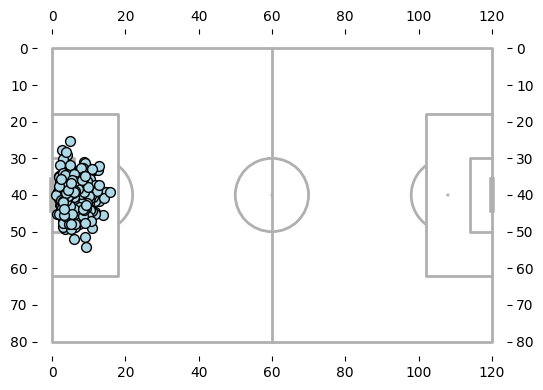

In [47]:
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

ax.scatter(df.loc[df['goalkeeper_type'] == "Collected","x"], df.loc[df['goalkeeper_type'] == "Collected","y"], c='lightblue', s=50, edgecolors='black', zorder=5)